# Thumbnail Embedding Generation

In [1]:
from src.model import ClayMAEModule
import src.ollie_clay_utils as clay_utils
zarr_path = "data/infra_tiles_v9.zarr"
out_dir='data/embeddings'

#clay_utils.get_embeddings_single_process(z, [1], model, out_dir='data/embeddings')
clay_utils.run_pipeline(zarr_path, out_dir)

Running pipeline


/home/sai/miniconda3/envs/claymodel/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Processing detections:   9%|▉         | 45/504 [00:47<11:53,  1.55s/detection]/home/sai/miniconda3/envs/claymodel/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing detections: 100%|██████████| 504/504 [13:08<00:00,  1.56s/detection]


Reading embeddings
data/infra_tiles_v9.zarr
copy /detect_id (52428,) object


/home/sai/miniconda3/envs/claymodel/lib/python3.11/site-packages/zarr/storage.py:585: FutureWarning: missing object_codec for object array; this will raise a ValueError in version 3.0
  warnings.warn(


copy /detect_lat (52428,) float32
copy /detect_lon (52428,) float32
copy /label (52428,) object
copy /tiles_s1 (52428, 100, 100, 2) uint8
copy /tiles_s2 (52428, 100, 100, 4) uint8
all done: 6 copied, 0 skipped, 3,146,938,272 bytes copied


# Analyze Embeddings

In [4]:
import numpy as np
import pandas as pd
from sklearn import decomposition
import plotly.express as px
import zarr
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import embedding_utils as emb_utils

z=zarr.open('data/infra_tiles_v9_embeddings.zarr', mode='r')
ns=zarr.open('data/infra_tiles_nearshore_v1.zarr', mode='r')

ns_df=pd.DataFrame({'label':ns['label'][:], 'detect_id':ns['detect_id'][:]})
z_df=pd.DataFrame({'detect_id':z['detect_id'][:],'label':z['label'][:]})
df=pd.merge(z_df, ns_df, on='detect_id', how='left')

df['label']=np.where(df['label_y']=='aquaculture', 'aquaculture', df['label_x'])
labs=df['label'][:]


#labs=z['label'][:]
ids=z['detect_id'][:]
s1=np.vstack(z['s1_embeddings'][:])
s2=np.vstack(z['s2_embeddings'][:])

df=pd.DataFrame({'label':labs, 'detect_id':ids})

pca = decomposition.PCA(n_components=3)

#geometric mean 

#emb = (s1 + s2)/2

#emb = np.concatenate((s1, s2), axis=1)
 
emb=s2*0.2+s1*0.8

# print(emb)
df['pca'] = list(pca.fit_transform(emb))

df['x'] = df['pca'].apply(lambda x: x[0])
df['y'] = df['pca'].apply(lambda x: x[1])
df['z'] = df['pca'].apply(lambda x: x[2])
df.reset_index(inplace=True)

# Initialize interactive figure
fig = go.FigureWidget()

# Color by label
#cmap = {'wind': 'green', 'oil': 'orange', 'other': 'blue', 'noise': 'red'}
#colors = [cmap[label] for label in df['label']]

for label in df['label'].unique():
    df_label = df[df['label'] == label]
    fig.add_trace(go.Scatter3d(
        x=df_label['x'],
        y=df_label['y'],
        z=df_label['z'],
        mode='markers',
        marker=dict(
            size=3,
            #color=cmap[label],
            opacity=0.3
        ),
        name=label,
        meta=df_label['index']

    ))

fig.update_layout(
    template="gridon",
    modebar_add=['drawclosedpath'],
    height=1000,
    scene=dict(
        xaxis=dict(title='PCA 1'),
        yaxis=dict(title='PCA 2'),
        zaxis=dict(title='PCA 3')
    ),
    legend=dict(title="Labels")
)

# Create output widget for capturing callback output
out = widgets.Output()

# Callback function
@out.capture()
def base_click(trace, points, selector):
    if points.point_inds:
        #remove traces with name="selected"

        fig.data = [trace for trace in fig.data if 'selected' not in trace.name]
        pt_id = points.point_inds[0]
        index=trace.meta[pt_id]

        idxs=emb_utils.find_similar(z, index, widget=out, fig=fig, top_n=10, metric='cosine', labs=labs, embeddings=emb)
        emb_utils.highlight_traces(fig, idxs)
         
        
# Attach callback to each trace in the figure
for trace in fig.data:
    trace.on_click(base_click)

# Display the figure and output widget side-by-side
widgets.VBox([fig, out])

    'data': [{'marker': {'opacity': 0.3, 'size': 3},
              'meta': array…

/home/sai/miniconda3/envs/claymodel/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[10:36:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




              precision    recall  f1-score   support

       noise       0.92      0.97      0.95      2001
         oil       0.98      0.99      0.98      4001
       other       0.81      0.40      0.54       354
        wind       1.00      1.00      1.00      4522

    accuracy                           0.97     10878
   macro avg       0.93      0.84      0.87     10878
weighted avg       0.97      0.97      0.97     10878



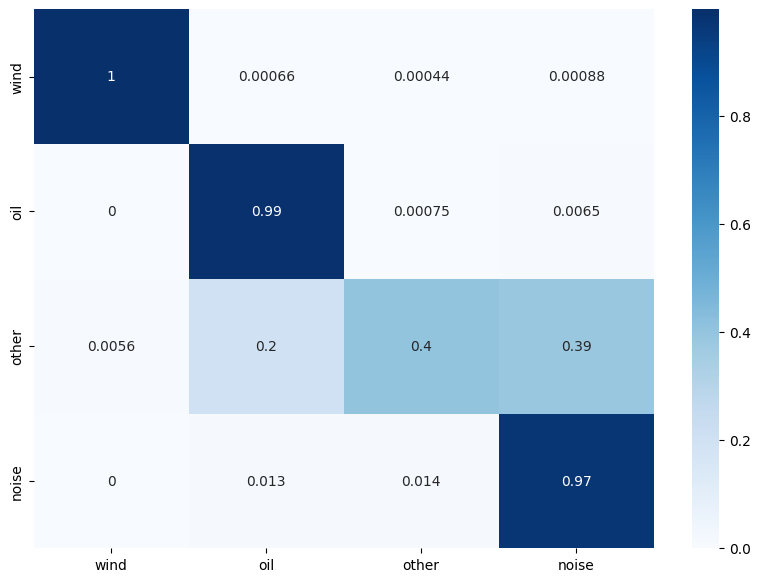

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import zarr
import numpy as np
import matplotlib.pyplot as plt
import torch


# Open the Zarr datasets
ix = zarr.open('data/infra_tiles_v9.zarr.index', mode='r')
z = zarr.open('data/infra_tiles_v9_embeddings_noloc.zarr', mode='r')

# Load indices
train_idxs = ix['train']['all']['train'][:]
val_idxs = ix['train']['all']['val'][:]
train_idxs = np.concatenate((train_idxs, val_idxs))
test_idxs = ix['test']['base'][:]

# Load data
labs = z['label'][:]
ids = z['detect_id'][:]
s1 = np.vstack(z['s1_embeddings'][:])
s2 = np.vstack(z['s2_embeddings'][:])

# Define class mapping
CLASSES = {"wind": 0, "oil": 1, "other": 2, "noise": 3}
INV_CLASSES = {v: k for k, v in CLASSES.items()}  # Inverse mapping

labs = np.array([CLASSES[l] for l in labs])

# Average the s2 and s1 embeddings

emb=s2*0.2+s1*0.8
#emb = s1
# PCA (optional)
#pca = decomposition.PCA(n_components=10)
#emb = pca.fit_transform(emb)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = emb[train_idxs], emb[test_idxs], labs[train_idxs], labs[test_idxs]
params={'device': 'cuda', 'eta': 0.01, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'n_jobs': -1, 'tree_method': 'hist'}
# Initialize and train the classifier
clf = xgb.XGBClassifier(**params)

clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

# Map numerical labels back to original string labels
y_test_str = [INV_CLASSES[y] for y in y_test]
y_pred_str = [INV_CLASSES[y] for y in y_pred]

# Display classification report with original labels
print(classification_report(y_test_str, y_pred_str))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, xticklabels=list(CLASSES.keys()), yticklabels=list(CLASSES.keys()), cmap='Blues')
plt.show()

              precision    recall  f1-score   support

 aquaculture       0.50      0.08      0.13        26
       noise       0.98      1.00      0.99      1032

    accuracy                           0.98      1058
   macro avg       0.74      0.54      0.56      1058
weighted avg       0.97      0.98      0.97      1058



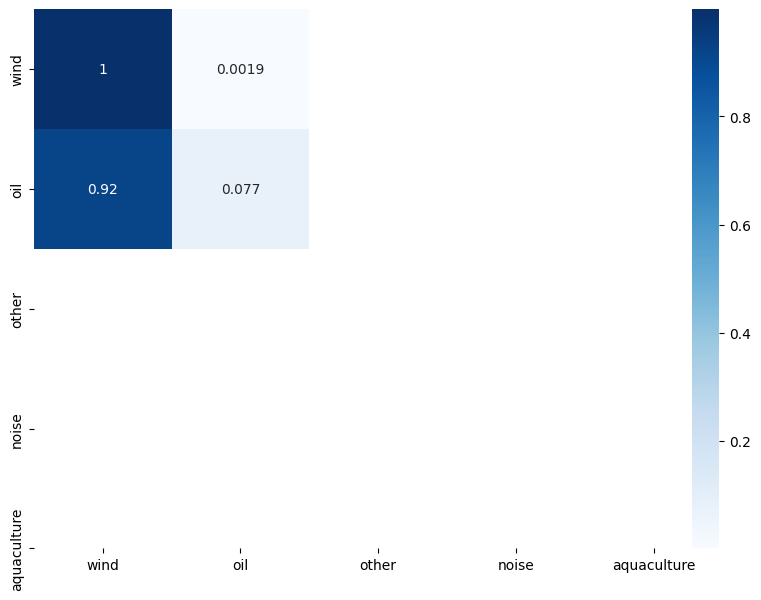

In [63]:
from sklearn.model_selection import train_test_split
import numpy as np
import zarr
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import zarr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ns=zarr.open('data/infra_tiles_nearshore_v1.zarr', mode='r')
z=zarr.open('data/infra_tiles_v9_embeddings.zarr', mode='r')

ns_df=pd.DataFrame({'label':ns['label'][:], 'detect_id':ns['detect_id'][:]})
z_df=pd.DataFrame({'detect_id':z['detect_id'][:], 's1_emb':list(z['s1_embeddings'][:]), 's2_emb':list(z['s2_embeddings'][:])})

df=pd.merge(ns_df, z_df, on='detect_id', how='left')

df=df[df['label']!='skip'].dropna()

CLASSES = {"wind": 0, "oil": 0, "other": 0, "noise": 0, "aquaculture": 1}
INV_CLASSES = {v: k for k, v in CLASSES.items()}  # Inverse mapping

ns_lab = np.array([CLASSES[l] for l in df['label']])

ns_emb = np.vstack(df['s2_emb']) * np.vstack(df['s1_emb']) # Using s2 embeddings

X_train, X_test, y_train, y_test = train_test_split(ns_emb, ns_lab, test_size=0.2, random_state=42)
params={'device': 'cuda', 'eta': 0.01, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'n_jobs': -1, 'tree_method': 'hist'}
clf=xgb.XGBClassifier(**params)

clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

# Map numerical labels back to original string labels
y_test_str = [INV_CLASSES[y] for y in y_test]
y_pred_str = [INV_CLASSES[y] for y in y_pred]

# Display classification report with original labels
print(classification_report(y_test_str, y_pred_str))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, xticklabels=list(CLASSES.keys()), yticklabels=list(CLASSES.keys()), cmap='Blues')
plt.show()


#mask=ns['label'][:]=='aquaculture'
#ixs=np.where(mask)[0]
#a_ix=ns['detect_id'][ixs]
#a_ixs=np.where(np.isin(z['detect_id'][:], a_ix))[0]




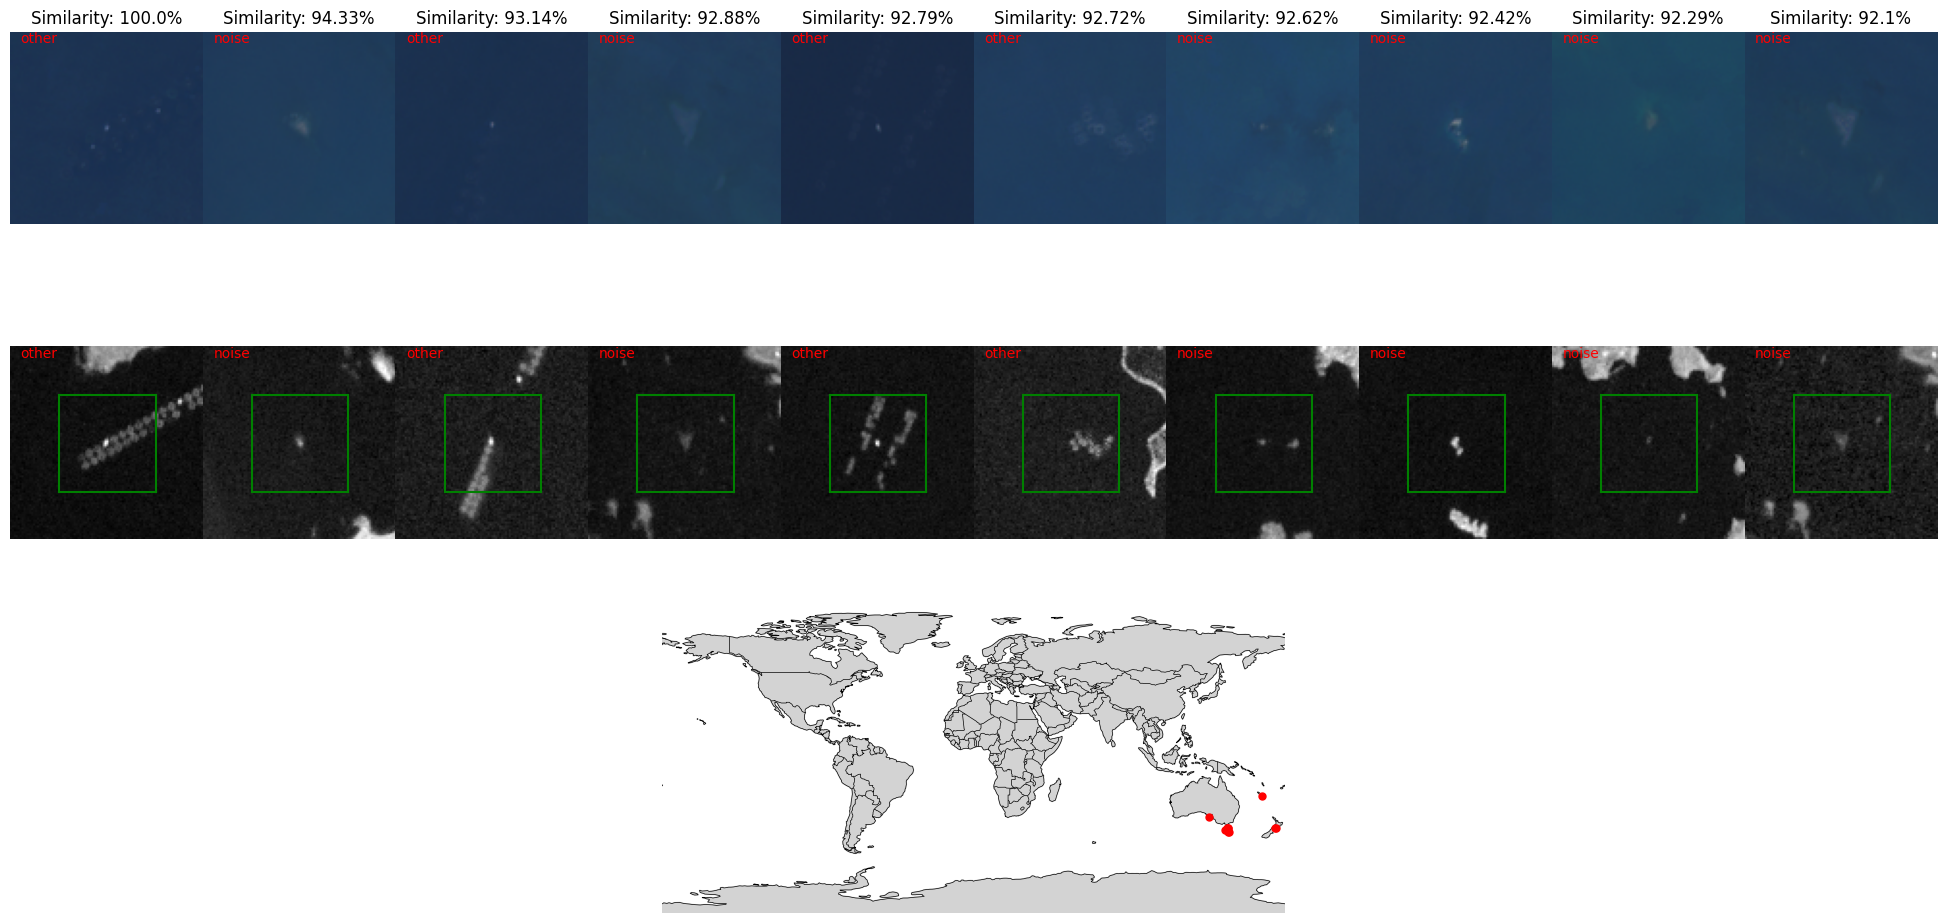

array([47796, 45283, 45467, 44191, 44141, 44064, 48045, 48077, 48163,
       46530])

In [5]:
import pandas as pd
import embedding_utils as emb_utils
import zarr
ns=zarr.open('data/infra_tiles_nearshore_v1.zarr', mode='r')
df=pd.DataFrame({'label':ns['label'][:], 'detect_id':ns['detect_id'][:]})
ids=df[df['label']=='aquaculture']['detect_id'].values
z=zarr.open('data/infra_tiles_v9_embeddings.zarr', mode='r')

emb_utils.find_similar(z, detect_id=ids[3], top_n=10, metric='braycurtis')

# Cluster Embeddings

In [7]:
z=zarr.open('data/infra_tiles_v9_embeddings.zarr', mode='r')
df=pd.DataFrame({'label':z['label'][:], 'detect_id':z['detect_id'][:], 's1_emb':list(z['s1_embeddings'][:]), 's2_emb':list(z['s2_embeddings'][:])})


,label,detect_id,s1_emb,s2_emb
0,noise,S1AB_AD_MEDIAN_COMP_20170131T000000_20170730T0...,"[[0.25089428, -0.07610704, -0.046475668, 0.118...","[[-0.06550391, -0.35842717, 0.04809379, -0.077..."
1,oil,S1AB_AD_MEDIAN_COMP_20170902T000000_20180301T0...,"[[0.20669162, -0.033590104, -0.033622377, 0.10...","[[0.096807756, -0.27544963, -0.08924049, -0.06..."
2,oil,S1AB_AD_MEDIAN_COMP_20201003T000000_20210401T0...,"[[0.21644597, -0.027328495, -0.013750063, 0.07...","[[-0.09192191, -0.24038558, -0.0871303, -0.040..."
3,noise,S1AB_AD_MEDIAN_COMP_20170603T000000_20171130T0...,"[[0.24446964, -0.011154252, -0.048551686, 0.12...","[[-0.060734794, -0.28349793, -0.035759285, -0...."
4,wind,S1AB_AD_MEDIAN_COMP_20180902T000000_20190301T0...,"[[0.24715383, -0.033720113, -0.098830685, 0.09...","[[0.0043527884, -0.182769, -0.18582983, -0.072..."
...,...,...,...,...
52423,oil,S1AB_AD_MEDIAN_COMP_20230101T000000_20230701T0...,"[[0.12711126, -0.015245741, -0.1306915, 0.1578...","[[-0.090422414, -0.2709021, 0.081598036, -0.10..."
52424,noise,S1AB_AD_MEDIAN_COMP_20230101T000000_20230701T0...,"[[0.29347494, 0.005732568, -0.099058904, 0.118...","[[-0.0508787, -0.21271473, 0.074995376, -0.065..."
52425,noise,S1AB_AD_MEDIAN_COMP_20230101T000000_20230701T0...,"[[0.20262797, -0.01439622, -0.0425968, 0.17911...","[[-0.17184521, -0.3312497, -0.0037378273, -0.1..."
52426,noise,S1AB_AD_MEDIAN_COMP_20230101T000000_20230701T0...,"[[0.2443507, -0.06858005, -0.09096312, 0.14922...","[[-0.121637836, -0.22974297, 0.049229167, -0.1..."


In [2]:
import umap
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn import decomposition
import plotly.express as px
import zarr
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import embedding_utils as emb_utils

z=zarr.open('data/infra_tiles_v9_embeddings.zarr', mode='r')
ns=zarr.open('data/infra_tiles_nearshore_v1.zarr', mode='r')

ns_df=pd.DataFrame({'label':ns['label'][:], 'detect_id':ns['detect_id'][:]})
z_df=pd.DataFrame({'detect_id':z['detect_id'][:],'label':z['label'][:], 's1_emb':list(z['s1_embeddings'][:]), 's2_emb':list(z['s2_embeddings'][:])})
df=pd.merge(z_df, ns_df, on='detect_id', how='left')

df['label']=np.where(df['label_y']=='aquaculture', 'aquaculture', df['label_x'])
df.reset_index(inplace=True)

labs=df['label'][:]


#labs=z['label'][:]
ids=df['detect_id'][:]
s1=np.vstack(df['s1_emb'])
s2=np.vstack(df['s2_emb'])

emb=s2*0.2+s1*0.8
#db = DBSCAN(eps=0.15, min_samples=10).fit(emb)
db = HDBSCAN(min_cluster_size=10, n_jobs=-1).fit(emb)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
labels = db.labels_

df['cluster']=labels.astype(str)
#get mode of label by cluster 
labmode=df.groupby('cluster')['label'].agg(pd.Series.mode).reset_index().rename(columns={'label':'cluster_label_mode'})
df=pd.merge(df, labmode, on='cluster', how='left')

df['cluster_label']=df['cluster_label_mode']+'_'+df['cluster']
confusion_matrix = pd.crosstab(df['label'], df['cluster_label'], rownames=['Label'], colnames=['Cluster'])
#df.sort_values('cluster_label', inplace=True)
confusion_matrix

Cluster,noise_0,noise_1,noise_10,noise_11,noise_12,noise_13,noise_14,noise_20,noise_22,noise_24,...,wind_86,wind_87,wind_89,wind_91,wind_92,wind_93,wind_94,wind_95,wind_98,wind_99
Label,,,,,,,,,,,,,,,,,,,,,
aquaculture,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
noise,24,18,12,12,14,32,10,34,11,126,...,0,0,0,0,0,0,0,0,0,0
oil,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
other,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wind,0,0,0,0,0,0,0,0,0,0,...,53,78,44,41,74,11,23,11,40,40


In [ ]:
group='cluster_label'

#reducer=umap.UMAP(n_components=3, metric='cosine', n_neighbors=15, min_dist=0.5)
reducer = decomposition.PCA(n_components=3)

df['reduced'] = list(reducer.fit_transform(emb))

df['x'] = df['reduced'].apply(lambda x: x[0])
df['y'] = df['reduced'].apply(lambda x: x[1])
df['z'] = df['reduced'].apply(lambda x: x[2])

# Initialize interactive figure
fig = go.FigureWidget()

# Color by label
#cmap = {'wind': 'green', 'oil': 'orange', 'other': 'blue', 'noise': 'red'}
#colors = [cmap[label] for label in df['label']]

for label in df[group].unique():
    df_label = df[df[group] == label]
    fig.add_trace(go.Scatter3d(
        x=df_label['x'],
        y=df_label['y'],
        z=df_label['z'],
        mode='markers',
        marker=dict(
            size=3,
            #color=cmap[label],
            opacity=0.3
        ),
        name=label,
        hovertext=df_label['label'],
        meta=df_label['index']

    ))

fig.update_layout(
    template="gridon",
    modebar_add=['drawclosedpath'],
    height=1000,
    scene=dict(
        xaxis=dict(title='Component 1'),
        yaxis=dict(title='Component 2'),
        zaxis=dict(title='Component 3')
    ),
    legend=dict(title="Labels")
)

# Create output widget for capturing callback output
out = widgets.Output()

# Callback function
@out.capture()
def base_click(trace, points, selector):
    if points.point_inds:
        fig.data = [trace for trace in fig.data if 'selected' not in trace.name]
        pt_id = points.point_inds[0]
        index=trace.meta[pt_id]

        idxs=emb_utils.find_similar(z, index, widget=out, fig=fig, top_n=10, metric='cosine', labs=df[group], embeddings=emb)
        emb_utils.highlight_traces(fig, idxs)
         
        
# Attach callback to each trace in the figure
for trace in fig.data:
    trace.on_click(base_click)

# Display the figure and output widget side-by-side
widgets.VBox([fig, out])

    'data': [{'hovertext': array(['noise', 'noise', 'noise', 'noise', 'noise', '…